In [1]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
import datetime

C:\Users\tient\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
PATH = "data/titanic/"

In [ ]:
os.listdir(PATH)

In [ ]:
# try to read the file with the predefined types (ML's courses lecture 3)
# pclass : object
# cabin : object
# embarked: object

When the data set is large (hundred millions entries, using this technique can speed up input reading process a lot, saving so much time!

In [3]:
train = pd.read_csv(f'{PATH}train.csv')
test = pd.read_csv(f'{PATH}test.csv')

In [14]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Fare_Per_Person,Age*Class,IsAlone,Title,Has_Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,1,1,0,A/5 21171,0,NaN,S,2,3.62500,66,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2,1,0,PC 17599,3,C85,C,2,35.64165,38,0,3,1
2,3,1,3,"Heikkinen, Miss. Laina",female,1,0,0,STON/O2. 3101282,1,NaN,S,1,7.92500,78,1,2,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2,1,0,113803,3,C123,S,2,26.55000,35,0,3,1
4,5,0,3,"Allen, Mr. William Henry",male,2,0,0,373450,1,NaN,S,1,8.05000,105,1,1,0


In [ ]:
test.head()

In [ ]:
train.shape, test.shape

In [ ]:
train.columns

Try to one-hot encode categorical data if there are less than 6 level, otherwise turn it into a number.

In [4]:
# train_cats?
# apply_cats?
train_cats(train)
train_cats(test)

In [6]:
?train_cats

In [ ]:
?proc_df

In [ ]:
# y = train.Survived
# x = train.drop('Survived', axis=1)

In [5]:
# proc_df
x,y,nas = proc_df(train, 'Survived', max_n_cat=6)

In [6]:
x_test, _, nas = proc_df(test, max_n_cat=6)

In [18]:
x.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,...,IsAlone,Title,Has_Cabin,Sex_female,Sex_male,Sex_nan,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,3,109,1,1,0,524,0,0,2,...,0,1,0,0,1,0,0,0,1,0
1,2,1,191,2,1,0,597,3,82,2,...,0,3,1,1,0,0,1,0,0,0
2,3,3,354,1,0,0,670,1,0,1,...,1,2,0,1,0,0,0,0,1,0
3,4,1,273,2,1,0,50,3,56,2,...,0,3,1,1,0,0,0,0,1,0
4,5,3,16,2,0,0,473,1,0,1,...,1,1,0,0,1,0,0,0,1,0


In [ ]:
x_test.head()

In [7]:
data = [train, test]

In [8]:
# add FamilySize
for df in data:
    df['FamilySize']=df['SibSp']+df['Parch']+1

In [9]:
for df in data:
    age_avg = df['Age'].mean()
    age_std = df['Age'].std()
    age_null_count = df['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    df['Age'][np.isnan(df['Age'])] = age_null_random_list
    df['Age'] = df['Age'].astype(int)

C:\Users\tient\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
# add Fare per person
for df in data:
    df['Fare_Per_Person']=df['Fare']/(df['FamilySize'])
    df['Age*Class']=df['Age']*df['Pclass']

In [11]:
for df in data:
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

In [12]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [13]:
for df in data:
    df['Title'] = df['Name'].apply(get_title)

In [14]:
for df in data:
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

In [15]:
for df in data:
    df['Fare'] = df['Fare'].fillna(train['Fare'].median())
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    df['Title'] = df['Title'].map(title_mapping)
    df['Title'] = df['Title'].fillna(0)
    
    # Mapping Fare
    df.loc[ df['Fare'] <= 7.91, 'Fare'] 						        = 0
    df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare']   = 2
    df.loc[ df['Fare'] > 31, 'Fare'] 							        = 3
    df['Fare'] = df['Fare'].astype(int)
    
    # Mapping Age
    df.loc[ df['Age'] <= 16, 'Age'] 					       = 0
    df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
    df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 2
    df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 3
    df.loc[ df['Age'] > 64, 'Age'] = 4 ;

In [16]:
for df in data:
    df['Has_Cabin'] = df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [17]:
cols = [c for c in x_test.columns if c not in x.columns]

In [18]:
cols

['Fare_na']

In [19]:
x_test = x_test.drop(cols, axis=1)

In [22]:
to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']

In [23]:
x_test = x_test.drop(to_drop, axis=1)

In [24]:
x = x.drop(to_drop, axis=1)

In [ ]:
# split into training and validation sets

In [ ]:
?m.score

In [20]:
# train the model
m = RandomForestClassifier(n_estimators = 80, max_features=0.5, n_jobs = -1, oob_score=True)
%time m.fit(x,y)
print(m.oob_score_)

Wall time: 193 ms
0.8372615039281706


In [ ]:
# calculate the score on validation set

Now I'll try to interpret the model with some basic techniques

In [ ]:
??rf_feat_importance

In [10]:
# Feature importance
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
11,Sex_male,0.184560
10,Sex_female,0.144180
19,Age*Class,0.091317
6,Ticket,0.082780
18,Fare_Per_Person,0.082400
7,Fare,0.063425
2,Name,0.063419
0,PassengerId,0.054728
3,Age,0.052950
1,Pclass,0.051714


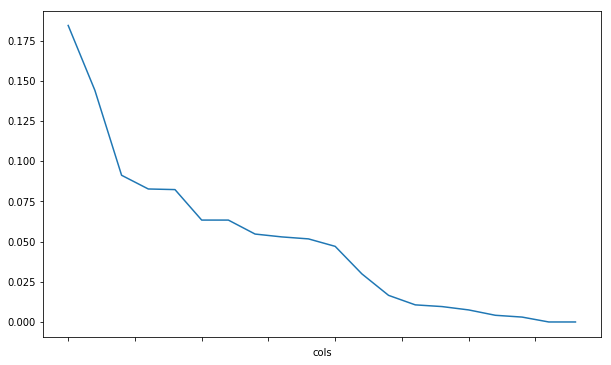

In [11]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [12]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

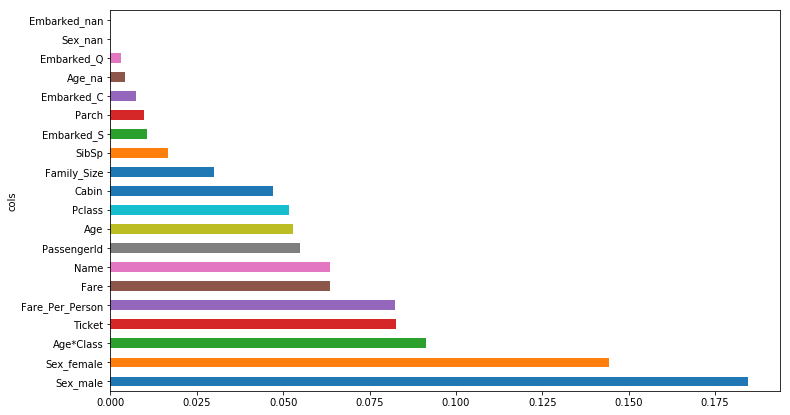

In [13]:
plot_fi(fi)

In [14]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

16

In [15]:
x_keep = x[to_keep].copy()

In [34]:
m = RandomForestClassifier(n_estimators = 20, min_samples_leaf = 3, n_jobs = -1, oob_score=True)
%time m.fit(x_keep,y)
print(m.oob_score_)

Wall time: 130 ms
0.813692480359147


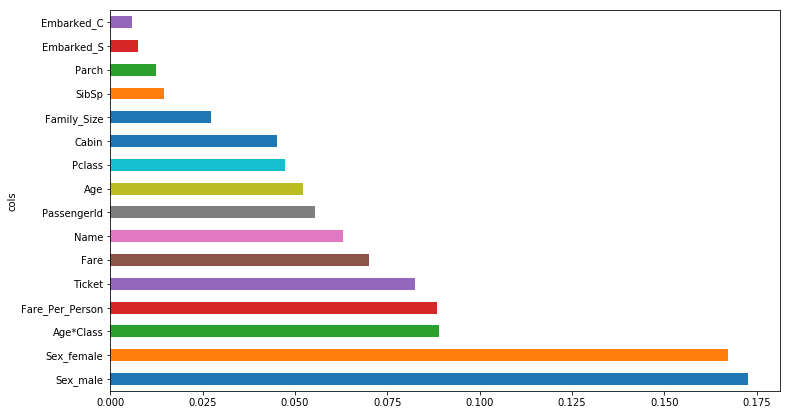

In [17]:
fi = rf_feat_importance(m, x_keep)
plot_fi(fi);

In [42]:
cols = [c for c in x_test.columns if c not in x.columns]; cols

[]

In [19]:
x_test = x_test.drop(cols, axis=1)

In [21]:
# prediction
predicted = m.predict(x_test)

In [22]:
my_submission = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predicted})

In [23]:
my_submission[my_submission.Survived==0].count()

PassengerId    260
Survived       260
dtype: int64

In [24]:
my_submission.to_csv('titanic_submission.csv', index=False)

1st - rank 8k
2nd - use OHE - 7k
3rd - tunning the random forest with 80 trees -> just pass the 5k rank

Add some more continous features -> train for the best oob score -> rank 3k

Try to remove some features with low importance <0.02 but the model turns out to be worse?

==> in case of few data, it's better to increase features rather than remove them

After experimenting with some feature engineering, my conclusion: fastai's preprocessing is equally or more efficient than manual feature engineering. Different classifiers may have slightly different results. RandomForest is still a very good technique in ML => should be able to understand thoroughly.
/n
Next steps: more features? Goal: score 0.8 or above